# Natural Computing

This is an exercise from 2019/2 period of the course "Natural Computing" at UFES, in Vitória/ES - Brazil.

Task: Compare different nature-inspired optimization algorithms.

Master's degree candidate: Bruno Carvalho

Last modifications: 2019-09-15.


## Algorithms

- GA - Genetic Algorithms
- PSO - Particle Swarm Optimization
- BB-PSO - Bare-Bone Particle Swarm Optimization
- ES - Evolution Strategy
- CMA-ES - Covariance Matrix Evolutionary Strategy algorithm



In [1]:
import os
import sys
import time
import itertools
import random
import platform
import subprocess
import re

import psutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt

from benchmarks import *

%matplotlib inline
#%matplotlib notebook
%config InlineBackend.figure_format = 'png'


In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
# wider cells
pd.set_option('display.width', 1000)

# System

In [5]:
def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode('utf-8').strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

In [6]:
mem = psutil.virtual_memory()
swap = psutil.swap_memory()
print('OS', os.name)
print('system', platform.system(), platform.release())
print('cpu', platform.processor())
print('processors', psutil.cpu_count(), get_processor_name())
print('memory', f'{(mem.total / 1024 / 1024 / 1024):4.1f} GB')
print('python', platform.python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('matplotlib', mpl.__version__)

OS posix
system Linux 5.0.0-27-generic
cpu x86_64
processors 6  Intel(R) Core(TM) i5-9600K CPU @ 3.70GHz
memory 31.3 GB
python 3.6.8
numpy 1.17.2
pandas 0.25.1
matplotlib 3.1.1


# Default parameters

In [7]:
#benchmarks = ['ackley_function', 'sphere_function', 'rastrigin_function', 'rosenbrock_function', 'schwefel']
benchmarks = ['ackley_function', 'sphere_function']

py_globals = globals()

execution_dict = {
    'time_elapsed': 0,
    'algorithm': '',
    'metrics': {
        'best': [],
        'all_best': 0.0,
        'all_worst': 0.0,
        'time': [],
        'objective': [],
        'scores': [],
    },
    'n_eval': 0,
    'max_func_eval': 100,
}

compare_cols = [
    'algorithm',
    'benchmark',
    'seed',
    'population',
    'dimension',
    'max_iter',
    'upper_bound',
    'lower_bound',
    'best',
    'worst',
    'mean',
    'time',
    'n_func_eval'
]
compare_data = pd.DataFrame(columns=compare_cols)

In [8]:
def ga_optimizer(obj_func, parameters):
    """
    
    Crossover: arithmetic, for 100%
    Mutation: 1%, normal distribution
    Elitism: keep 'k' best

    Inspired by:
    https://github.com/7ossam81/EvoloPy/blob/master/GA.py

    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    population = parameters.get('population', 100)
    crossover_rate = parameters.get('crossover_rate', 1.0)
    mutation_rate = parameters.get('mutation_rate', 0.01)
    best_to_keep = parameters.get('best_to_keep', 2)
    crossover_alpha = parameters.get('crossover_alpha', 0.25)
    max_eval = parameters.get('max_eval', 0)
    verbose = parameters.get('verbose', 0)
    max_func_eval = parameters.get('max_func_eval', 100)
    
    np.random.seed(seed)
    
    # Input Objective function has variable dimensions
    # consider equi-distance "square"
    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    n_eval = 0
    
    # allocate memory
    exec_info['metrics']['time'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['best'] = np.zeros([max_iterations, dimension], dtype='float')
    #exec_info['metrics']['objective'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['objective'] = []
    exec_info['metrics']['scores'] = np.full([max_iterations, population], np.inf, dtype='float')

    begin = time.time()

    space = np.random.uniform(0, 1, [population, dimension]) * (upper[0] - lower[0]) + lower[0]
    scores = np.random.uniform(0.0, 1.0, population) + 1000
    
    # crossover takes 95% of running time!!
    def crossover(space, scores):
        #population, dimension = space.shape
        search_space = np.zeros_like(space) + np.random.uniform(0, 1)
        #search_space = np.zeros_like(space)
        search_space[0:best_to_keep, :] = space[0:best_to_keep, :]
        
        # renew BETA every generation
        beta = np.random.uniform(-crossover_alpha, 1 + crossover_alpha)
        
        for cross  in range(best_to_keep + 1, population - 1, 2):

            # using SET parents will always be different
            #parents = set()
            
            # using LIST parents can repeat!
            parents = []
            
            parent1_idx = np.random.randint(0, population)
            parent2_idx = np.random.randint(0, population)
            
            parents.append(parent1_idx)
            parents.append(parent2_idx)

            """
            while len(parents) < 2:
                parent1_idx = np.random.randint(0, population)
                parent2_idx = np.random.randint(0, population)
            
                if scores[parent1_idx] > scores[parent2_idx]:
                    # p1 is better then p2
                    parents.add(parent1_idx)
                else:
                    parents.add(parent2_idx)               
            """
            
            lp = list(parents)
            parent1 = space[lp[0], :]
            parent2 = space[lp[1], :]
            
            # ARITHMETIC CROSSOVER
            child1 = parent1 * beta + (1.0 - beta) * parent2
            child2 = parent2 * beta + (1.0 - beta) * parent1
            
            crossover_chance = np.random.uniform(0.0, 1.0)

            if crossover_chance < crossover_rate:
                search_space[cross, :] = np.copy(child1)
                search_space[cross + 1, :] = np.copy(child2)  
            else:
                search_space[cross, :] = np.copy(parent1)
                search_space[cross + 1, :] = np.copy(parent2)
            
            for j in range(dimension):
                search_space[cross, j] = np.clip(search_space[cross, j], lower[j], upper[j])
                search_space[cross + 1, j] = np.clip(search_space[cross + 1, j], lower[j], upper[j])
                
        return search_space
    
    def mutation(space, gen):
        n_mutate = np.int(population * mutation_rate)
        for m in range(n_mutate):
            # keep best => do not mutate
            rand_individual = np.random.randint(best_to_keep + 1, population)
            #rand_individual = np.random.randint(0, population)
            # decrease stdev with generations
            #stdev = 5.0 / np.sqrt(gen + 1)
            stdev = 2
            new_value = np.zeros(dimension)
            for j in range(dimension):
                new_value[j] = np.random.normal(space[rand_individual, j], stdev)
                new_value[j] = np.clip(new_value[j], lower[j], upper[j])

            # store
            space[rand_individual, :] = new_value

        return space
    
    def sort_iter(_space, _scores):
        idx = scores.argsort()
        _space = _space[idx]
        _scores = _scores[idx]
        return _space, _scores
    
    def eval_obj(func, _space):
        _scores = np.full(population, np.inf)
        for p in range(population):
            _scores[p] = func(_space[p, :])
        return _scores

    for i in range(dimension):
        # init search space inside bounds
        space[:, i] = np.random.uniform(0, 1, population) * (upper[i] - lower[i]) + lower[i]
    
    for _iter in range(0, max_iterations):
        
        # crossover
        space = crossover(space, scores)
        
        # mutation
        space = mutation(space, _iter)
        
        # evaluate objective
        scores = eval_obj(obj_func, space)
        n_eval += population
        
        # remove duplicates
        
        # sort
        space, scores = sort_iter(space, scores)
        
        # save
        exec_info['metrics']['scores'][_iter] = scores
        exec_info['metrics']['time'][_iter] = time.time() - begin
        exec_info['metrics']['best'][_iter] = space[0, :]
        #exec_info['metrics']['objective'][_iter] = scores[0]
        exec_info['metrics']['objective'].append(scores[0])
        
        if verbose and _iter % np.int((max_iterations + 1) / 5) == 0:
            print(
                f'\t\tIteration {_iter:05d},',
                f'f_min = {scores[0]:+13.5e},',
                f'x = {space[0, 0]:+13.5e}',
                f'n_eval = {n_eval:05d}',
                f'time = {time.time() - begin:8.3f}s'
            )

        if n_eval >= max_func_eval:
            print(f'\t\t   stopped max eval {n_eval}')
            break

    exec_info['algorithm'] = 'GA - Genetic Algorithm'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval
    exec_info['metrics']['all_best'] = scores[0]
    
    return exec_info

In [9]:
def pso_optimizer(obj_func, parameters):
    """

    Inspired by:
    https://github.com/7ossam81/EvoloPy/blob/master/PSO.py

    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    velocity_max = np.full(dimension, parameters.get('velocity_max', 5.0))
    max_func_eval = parameters.get('max_func_eval', 100)
    verbose = parameters.get('verbose', 0)
    
    np.random.seed(seed)
    
    w_max = parameters.get('w_max', 0.9)
    w_min = parameters.get('w_min', 0.2)

    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    exec_info['metrics']['scores'] = np.zeros(max_iterations, dtype='float')
    exec_info['metrics']['objective'] = []  #np.zeros(max_iterations, dtype='float')

    # inner variables
    
    c1 = 2.0
    c2 = 2.0
    
    velocity = np.full([population, dimension], 0.0)
    
    p_best_score = np.full(population, np.inf)
    p_best = np.full([population, dimension], 0.0)
    
    g_best_score = np.inf
    g_best = np.full(population, 0.0)
    
    space = np.full([population, dimension], 0.0)
    
    begin = time.time()

    # init fill
    for _d in range(dimension):
        rand_dim = np.random.uniform(0, 1, population)
        space[:, _d] = rand_dim * (upper[_d] - lower[_d]) + lower[_d]
    
    n_eval = 0
    for _iter in range(max_iterations):
        for _p in range(population):
            # keep inside bounds / search limits
            space[_p, :] = np.clip(space[_p, :], lower, upper)
            
            # eval
            score = obj_func(space[_p, :])
            n_eval += 1
            
            # check
            if p_best_score[_p] > score:
                p_best_score[_p] = score
                p_best[_p, :] = np.copy(space[_p, :])
            
            if g_best_score > score:
                g_best_score = score
                g_best = np.copy(space[_p, :])
        
        w = w_max - _iter * ((w_max - w_min) / max_iterations)
        
        for _p in range(population):
            r1 = np.random.random([dimension])
            r2 = np.random.random([dimension])
            
            v = velocity[_p, :]
            
            a1 = c1 * r1 * (p_best[_p, :] - space[_p, :])
            a2 = c2 * r2 * (g_best - space[_p, :])
            
            velocity[_p, :] = w * v + a1 + a2
            
            velocity[_p, :] = np.fmax(velocity[_p, :], -velocity_max)  # negative!!
            velocity[_p, :] = np.fmin(velocity[_p, :],  velocity_max)
            
            # UPDATE space
            space[_p, :] += velocity[_p, :]

        # save data to analyse and plot later
        exec_info['metrics']['scores'][_iter] = g_best_score
        #exec_info['metrics']['objective'][_iter] = g_best_score
        exec_info['metrics']['objective'].append(g_best_score)
        
        # some logging
        if verbose and _iter % np.int((max_iterations + 1) / 5.0) == 0:
            print(
                f'\t\tIteration {_iter:05d},',
                f'f_min = {g_best_score:+13.5e},',
                f'x = {p_best[0, 0]:+13.5e}',
                f'n_eval = {n_eval:05d}',
                f'time = {time.time() - begin:8.3f}s'
            )

        if n_eval >= max_func_eval:
            print(f'\t\t   stopped max eval {n_eval}')
            break

    # finished
    exec_info['algorithm'] = 'PSO - Particle Swarm Optimization'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval
    exec_info['metrics']['all_best'] = np.amin(exec_info['metrics']['objective'])

    return exec_info

In [10]:
def bb_pso_optimizer(obj_func, parameters):
    """


    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    verbose = parameters.get('verbose', 0)
    max_func_eval = parameters.get('max_func_eval', 100)

    np.random.seed(seed)

    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    exec_info['metrics']['scores'] = np.zeros(max_iterations, dtype='float')
    exec_info['metrics']['objective'] = []  #np.zeros(max_iterations, dtype='float')

    p_best_score = np.full(population, np.inf)
    p_best = np.full([population, dimension], 0.0)

    g_best_score = np.inf
    g_best = np.full(population, 0.0)

    begin = time.time()

    # init fill
    for _d in range(dimension):
        rand_dim = np.random.uniform(0, 1, population)
        p_best[:, _d] = rand_dim * (upper[_d] - lower[_d]) + lower[_d]

    n_eval = 0
    for _iter in range(max_iterations):
        for _p in range(population):

            # eval
            score = obj_func(p_best[_p, :])
            n_eval += 1

            # check
            if score < p_best_score[_p]:
                p_best_score[_p] = score

            if g_best_score > score:
                g_best_score = score
                g_best = np.copy(p_best[_p, :])

            # update positions
            mean = 0.5 * (g_best + p_best[_p, :])
            std = np.fabs(g_best - p_best[_p, :])
            tmp = np.random.normal(mean, std, dimension)
            p_best[_p, :] = np.clip(tmp, lower, upper)

        # save data to analyse and plot later
        exec_info['metrics']['scores'][_iter] = g_best_score
        #exec_info['metrics']['objective'][_iter] = g_best_score
        exec_info['metrics']['objective'].append(g_best_score)

        # some logging
        if verbose and _iter % np.int((max_iterations + 1) / 5.0) == 0:
            print(
                f'\t\tIteration {_iter:05d},',
                f'f_min = {g_best_score:+13.5e},',
                f'x = {p_best[0, 0]:+13.5e}',
                f'n_eval = {n_eval:05d}',
                f'time = {time.time() - begin:8.3f}s'
            )

        if n_eval >= max_func_eval:
            print(f'\t\t   stopped max eval {n_eval}')
            break

    # finished
    exec_info['algorithm'] = 'BBPSO'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval
    exec_info['metrics']['all_best'] = np.amin(g_best_score)

    return exec_info

In [11]:
def es_optimizer(obj_func, parameters):
    """
    
    Inspired by:
    - https://github.com/jakobj/python-es/blob/master/es/plain_es.py
    
    Some insights from:
    - https://github.com/MorvanZhou/Evolutionary-Algorithm/blob/master/tutorial-contents/Evolution%20Strategy/Evolution%20Strategy%20Basic.py
    - https://github.com/evopy/evopy/
    - https://github.com/drallensmith/pycma/blob/master/cma/evolution_strategy.py

    """
    seed = parameters.get('seed', 1)
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    max_iterations = parameters.get('max_iterations', 100)
    crossover_rate = parameters.get('crossover_rate', 1.0)
    mutation_rate = parameters.get('mutation_rate', 0.01)
    verbose = parameters.get('verbose', 0)
    max_func_eval = parameters.get('max_func_eval', 100)
    
    np.random.seed(seed)

    begin = time.time()
    n_eval = 0
    
    # Input Objective function has variable dimensions
    # consider equi-distance "square"
    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    n_eval = 0
    
    # allocate memory
    exec_info['metrics']['time'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['best'] = np.zeros([max_iterations, dimension], dtype='float')
    #exec_info['metrics']['objective'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['objective'] = []
    exec_info['metrics']['scores'] = np.full([max_iterations, population, 3], np.inf, dtype='float')

    begin = time.time()

    space = np.random.uniform(0, 1, [population, dimension])
    scores = np.random.uniform(0.0, 1.0, population)

    n_mut = 0
    c = 0.9
    _std = 1.0
    _mean = 0.0
    tau = 1 / np.sqrt(population)
    epson = 3


    for i in range(dimension):
        # init search space inside bounds
        space[:, i] = np.random.uniform(0, 1, population) * (upper[i] - lower[i]) + lower[i]
    
    for _iter in range(0, max_iterations):
        
        ps = n_mut / max_iterations
        if ps > 0.2:
            _std = _std / c
        elif ps < 0.2:
            _std = _std * c
        z = np.random.normal(_mean, _std, dimension)
        
        # evaluate objective
        #scores = eval_obj(obj_func, space)
        _scores = np.full([population, 3], np.inf)
        for p in range(population):
            tmp_i = space[p, :] + z
            tmp1 = obj_func(tmp_i)
            tmp2 = obj_func(space[p, :])
            _scores[p, 0] = tmp2
            _scores[p, 1] = tmp1
            if tmp1 < tmp2:
                space[p, :] = tmp_i
                n_mut += 1
                _scores[p, 2] = tmp1
            else:
                _scores[p, 2] = tmp2

            n_eval += 2
            
            if n_eval >= max_func_eval:
                print(f'\t\tstopped max eval {n_eval}')
                break
        
        # save
        exec_info['metrics']['scores'][_iter] = _scores
        exec_info['metrics']['time'][_iter] = time.time() - begin
        exec_info['metrics']['best'][_iter] = space[0, :]
        #exec_info['metrics']['objective'][_iter] = np.amin(_scores)
        exec_info['metrics']['objective'].append(np.amin(_scores))
        
        if verbose and _iter % np.int((max_iterations + 1) / 5) == 0:
            print(
                f'\t\tIteration {_iter:05d},',
                f'f_min = {scores[0]:+13.5e},',
                f'x = {space[0, 0]:+13.5e}',
                f'n_eval = {n_eval:05d}',
                f'time = {time.time() - begin:8.3f}s'
            )

        if n_eval >= max_func_eval:
            print(f'\t\t   stopped max eval {n_eval}')
            break


    exec_info['algorithm'] = 'ES'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval
    exec_info['metrics']['all_best'] = np.amin(_scores[:, 2])
    
    return exec_info

In [12]:
def cma_es_optimizer2(obj_func, parameters):
    """
    MATLAB code from https://en.wikipedia.org/wiki/CMA-ES
    """
    seed = parameters.get('seed', 10)
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    verbose = parameters.get('verbose', 0)
    max_iterations = parameters.get('max_iterations', 100)
    max_func_eval = parameters.get('max_func_eval', 100)
    
    exec_info = execution_dict.copy()
    
    np.random.seed(seed)

    begin = time.time()
    n_eval = 0
    N = dimension
    xmean = np.random.uniform(0, 1, N)
    sigma = 0.3
    stopfitness = 1e-10
    stopeval = 1e3 * N ** 2
  
    lambda_ = np.int(4 + 3 * np.log(N))
    mu = np.int(lambda_ / 2)
    linv = np.array(range(1, mu + 1))  # np.linspace
    weights = np.log(mu + 0.5) - np.log(linv).T
    weights = weights / np.sum(weights)
    mueff = np.sum(weights) ** 2 / np.sum(weights ** 2)
    
    exec_info['metrics']['scores'] = np.zeros([max_iterations, lambda_])
    exec_info['metrics']['time'] = np.zeros([max_iterations])
    exec_info['metrics']['best'] = np.zeros([max_iterations, dimension])
    exec_info['metrics']['objective'] = []  #np.zeros([max_iterations])

    cc = (4.0 + mueff / N) / (N + 4.0 + 2.0 * mueff / N)
    cs = (mueff + 2.0) / (N + mueff + 5)
    c1 = 2.0 / ((N + 1.3) ** 2 + mueff)
    cmu = np.fmin(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((N + 2) ** 2 + mueff))
    damps = 1.0 + 2.0 * np.fmax(0, np.sqrt((mueff - 1) / (N + 1)) - 1) + cs
                                                      
    pc = np.zeros(N, dtype='float')
    ps = np.zeros(N, dtype='float')
    B = np.eye(N, N, dtype='float')
    D = np.ones(N, dtype='float')
    C = B * np.diag(D ** 2) * B.T
    invsqrtC = B * np.diag(D ** -1) * B.T
    eigeneval = 0
    chiN = N ** 0.5 * (1 - 1 / (4 * N) + 1 / (21 * N ** 2))

    arfitness = np.zeros([max_iterations, lambda_], dtype='float')
    for _iter in range(max_iterations):
        arx = np.zeros((lambda_, N))
        for k in range(lambda_):
            x_up = sigma * np.dot(B, D * np.random.normal(0, 1, N))
            #print(x_up, xmean)
            #print(x_up.shape, xmean.shape)
            arx[k, :] = xmean + x_up
            #arfitness[_iter, k] = 1/obj_func(arx[k, :])
            arfitness[_iter, k] = obj_func(arx[k, :])
            n_eval = n_eval + 1
      
        #arindex = np.argsort(-arfitness[_iter, :])
        arindex = np.argsort(arfitness[_iter, :])
        arfitness[_iter, :] = arfitness[_iter, arindex]
        xold = xmean
        xmean = np.dot(weights, arx[arindex[0:mu], :])

        ps = (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * np.dot(invsqrtC, (xmean - xold) / sigma)
        
        _a = np.linalg.norm(ps)
        _e = (2 * n_eval / lambda_)
        _b = np.sqrt(1 - (1 - cs) ** _e)
        _c = _a / _b / chiN
        _d = 1.4 + 2 / (N + 1)
        hsig = _c < _d

        pc = (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * ((xmean - xold) / sigma)
        artmp = (1 / sigma) * (arx[arindex[0:mu]] - xold)

        _a = (1 - c1 - cmu)
        _b = (np.dot(pc, pc.T) + (1 - hsig) * cc * (2 - cc) * C)
        C = _a * C + c1 * _b + cmu * np.dot(np.dot(artmp.T, np.diag(weights)), artmp)
        
        sigma = sigma * np.exp((cs / damps) * (np.linalg.norm(ps) / chiN - 1))

        if n_eval - eigeneval > lambda_ / (c1 + cmu) / N / 10:
            eigeneval = n_eval
            C = np.triu(C) + np.triu(C, 1).T
            D, B = np.linalg.eig(C)
            D = np.sqrt(D)
            invsqrtC = np.dot(B, np.dot(np.diag(D ** -1), B.T))

        exec_info['metrics']['objective'].append(np.amin(arfitness[_iter, :]))
        
        if verbose and _iter % np.int((max_iterations + 1) / 5) == 0:
            print(
                f'\t\tIteration {_iter:05d},',
                f'f_min = {arfitness[_iter, 0]:+13.5e},',
                f'x = {xmean[0]:+13.5e}',
                f'n_eval = {n_eval:05d}',
                f'time = {time.time() - begin:8.3f}s'
            )

        if n_eval >= max_func_eval:
            print(f'\t\t   stopped max eval {n_eval}')
            break

        exec_info['metrics']['scores'][_iter] = arfitness[_iter]
        exec_info['metrics']['time'][_iter] = time.time() - begin
        exec_info['metrics']['best'][_iter] = xmean
        exec_info['metrics']['objective'][_iter] = arfitness[_iter, 0]

    #xmin = arx[arindex[0], :]

    exec_info['algorithm'] = 'CMA-ES'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval
    exec_info['metrics']['all_best'] = np.amin(arfitness[_iter, :])
    
    return exec_info

In [13]:
"""
https://github.com/AdeelMufti/WorldModels/blob/92238f0823f5e65da8655dfc15bc45cd0ec1a123/toy/cma-es.py
https://github.com/susanwe/ope_worldmodels/blob/2830f335c7acd927b34f4197dffcc51e7bf8146d/toy/cma-es.py
https://github.com/joaoVictorPinto/NaturalOptimization/blob/9bceb2d08b2174db28481a2ad7d94216da602d96/natural/CMAESSolver.py
https://github.com/Animadversio/Activation-Maximization-for-Visual-System/blob/ab4727ea69a81b22fc217e38f4b4b78ab69579dd/cmaes.py

"""
def cma_es_optimizer____old(obj_func, parameters):
    """
    
    Inspired by:
    https://github.com/jenkspt/CMA-ES
    

    Other implementations:
    - https://github.com/DEAP/deap/blob/master/deap/cma.py
    - https://github.com/RoetGer/CMAES/blob/master/cmaes/cmaes.py
    - https://github.com/CMA-ES/pycma/blob/master/cma/purecma.py
    - https://github.com/esa/pagmo/blob/master/PyGMO/algorithm/_cmaes.py
    - https://github.com/rock-learning/bolero/blob/master/bolero/optimizer/cmaes.py
    - https://github.com/benureau/models/blob/master/models/inverse/cma.py
    - https://github.com/LDNN97/Evolutionary-Optimization-Algorithms/blob/master/opti/cmaes.py
    - https://github.com/Nathaniel-Rodriguez/cma-es/blob/master/cmaes/cmaes.py
    - https://github.com/keurfonluu/StochOPy/blob/master/stochopy/evolutionary_algorithm.py
    
    C++
    - https://esa.github.io/pagmo2/docs/cpp/algorithms/cmaes.html
    
    Python Matrix multilication operator (@):
    - https://docs.python.org/3/library/operator.html

    Other refs:
    - http://blog.otoro.net/2017/10/29/visual-evolution-strategies/

    """
    seed = parameters.get('seed', 1)
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    max_iterations = parameters.get('max_iterations', 100)
    verbose = parameters.get('verbose', 0)

    # allocate memory
    exec_info['metrics']['time'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['best'] = np.zeros([max_iterations, dimension], dtype='float')
    exec_info['metrics']['scores'] = np.full([max_iterations, population, 3], np.inf, dtype='float')
    exec_info['metrics']['objective'] = np.zeros([max_iterations], dtype='float')

    np.random.seed(seed)
    begin = time.time()
    n_eval = 0

    k = 25      # Size of elite population
    X = np.random.normal(0, 1.24, (dimension, population))

    for i in range(max_iterations):
        n_eval += population
        fitness = obj_func(X.T)
        arg_topk = np.argsort(fitness)[:k]
        topk = X[:, arg_topk]

        # Covariance of topk but using mean of entire population
        centered = topk - X.mean(1, keepdims=True)
        C = np.matmul(centered, centered.T) / (k - 1)

        # Eigenvalue decomposition
        w, E = np.linalg.eigh(C)

        # Generate new population
        # Sample from multivariate gaussian with mean of topk
        N = np.random.normal(size=(d,n))
        X = topk.mean(1, keepdims=True) + np.matmul(np.matmul(E, np.diag(np.sqrt(w))), N)

        exec_info['metrics']['scores'][_iter] = fitness
        exec_info['metrics']['time'][_iter] = time.time() - begin
        exec_info['metrics']['best'][_iter] = topk[:, 0]
        exec_info['metrics']['objective'][_iter] = fitness[arg_topk[0]]
        
        if verbose and _iter % np.int((max_iterations + 1) / 5) == 0:
            print(f'iter {i}, z= {fitness[arg_topk[0]]:.2f}, x= {X[:, arg_topk[0]].round(2)}')
            """
            plt.clf()
            plt.imshow(Z, cmap='Oranges')
            _plot_points(X.T, low, high, size)
            plt.pause(.2)
            plt.draw()
            plt.savefig(f'plots/fig-{i}.jpg')
            """
        if n_eval >= max_func_eval:
            break

    
    exec_info['algorithm'] = 'CMA-ES'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval
    
    return exec_info

# GA - Genetic Algorithm

In [14]:
params = {
    'seed': 1,
    'dimension': 30,
    'max_iterations': 100,
    'population': 100,
    'upper': [30],
    'lower': [-30],
}

In [15]:
#%lprun -T ga_lprof.txt -f ga_optimizer ga_optimizer(py_globals['ackley_function'], params)

In [16]:
%%memit

results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 10000,
            'population': 100,
            'upper': [30],
            'lower': [-30],
            'verbose': 0,
            'max_func_eval': 0,
        }
        params['max_func_eval'] = params['population'] * 51
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = ga_optimizer(py_globals[bmrk], params)
        results.append(tmp_result.copy())
        #print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        #print('\t\tf=', tmp_result['metrics']['scores'][-1][:3])
        #print('\tx=')
        #for xv in tmp_result['metrics']['best'][-1]:
        #    print(f'\t\t {xv:+12.7e}')
        #    pass
        #print(tmp_result['metrics']['objective'])
        print('\t\t\t f_min =', tmp_result['metrics']['all_best'])
        """
        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'GA',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )
        """
print('')

Benchmark ackley_function
	Dimensions: 30, Seed=1
		   stopped max eval 5100
			 f_min = 0.02928980904896905
Benchmark sphere_function
	Dimensions: 30, Seed=1
		   stopped max eval 5100
			 f_min = 0.0013552866372660115

peak memory: 115.86 MiB, increment: 8.26 MiB


In [17]:
r_dim = results[0]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2][0])

Text(0, 0.5, 'log of f')

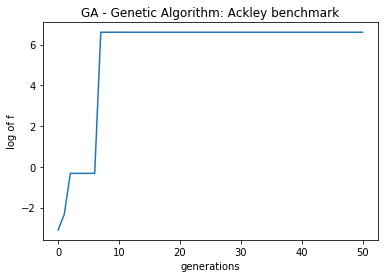

In [18]:
# change plot scale to LOG => better view
plt.plot(-np.log(r_dim['metrics']['objective']))

plt.title('GA - Genetic Algorithm: Ackley benchmark')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

# PSO - Particle Swarm Optimization algorithm

In [19]:
results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark function', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 1000,
            'population': 100,
            'upper': [30],
            'lower': [-30],
            'max_func_eval': 0,
        }
        params['max_func_eval'] = params['population'] * 51
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = pso_optimizer(py_globals[bmrk], params)
        results.append(tmp_result.copy())
        #print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        #print('\t\tf=', tmp_result['metrics']['scores'][-3:])
        print('\t\t\t f_min =', tmp_result['metrics']['all_best'])
        """
        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'PSO',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )
        """

Benchmark function ackley_function
	Dimensions: 30, Seed=1
		   stopped max eval 5100
			 f_min = 7.338044593146188
Benchmark function sphere_function
	Dimensions: 30, Seed=1
		   stopped max eval 5100
			 f_min = 62.208365506161705


In [20]:
r_dim = results[0]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2])

Text(0, 0.5, 'log(f_min)')

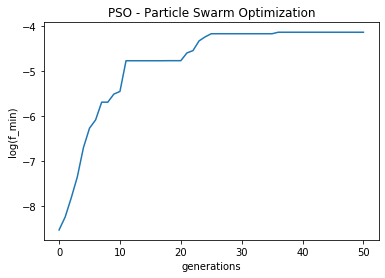

In [21]:
plt.plot(-np.log(r_dim['metrics']['objective']))
plt.title('PSO - Particle Swarm Optimization')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log(f_min)')

## BBPSO - Bare-bone Particle Swarm Optimization algorithm

Benchmark function ackley_function
	Dimensions: 30, Seed=1
		   stopped max eval 5100
			 f_min = 14.994787722133102
Benchmark function sphere_function
	Dimensions: 30, Seed=1
		   stopped max eval 5100
			 f_min = 194.304139148392


Text(0, 0.5, 'log of f')

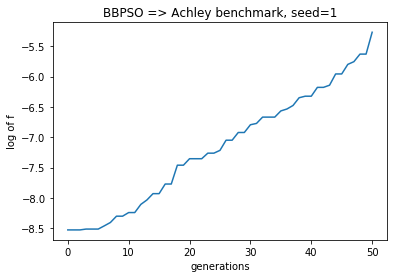

In [22]:
results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark function', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 20000,
            'population': 100,
            'upper': [30],
            'lower': [-30],
            'verbose': 0,
            'max_func_eval': 0,
        }
        params['max_func_eval'] = params['population'] * 51
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = bb_pso_optimizer(py_globals[bmrk], params)
        results.append(tmp_result.copy())
        #print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        #print('\t\tf=', tmp_result['metrics']['scores'][-3:])
        print('\t\t\t f_min =', tmp_result['metrics']['all_best'])
        """
        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'BBPSO',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )
        """

r_dim = results[0] # seed=1, ackley
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2])

plt.plot(-np.log(r_dim['metrics']['objective']))
plt.title('BBPSO => Achley benchmark, seed=1')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

/home/bgcarvalho/Documents/Personal/education/04_pos_graduacao/06_Mestrado-UFES/07_Computacao-natural/PINF-6073_natural-computing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'log of f')

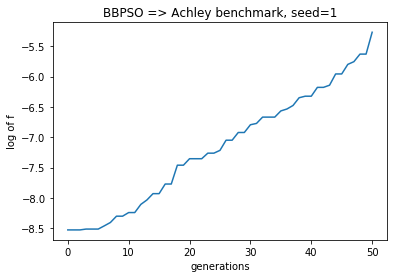

In [23]:
r_dim = results[0] # seed=1, ackley
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2])

plt.plot(-np.log(y_plot))
plt.title('BBPSO => Achley benchmark, seed=1')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

# ES - Evolutionary Strategy algorithm

Benchmark function ackley_function
	Dimensions: 30, Seed=1
		stopped max eval 102
		   stopped max eval 102
			 f_min = 20.733017536632296
Benchmark function sphere_function
	Dimensions: 30, Seed=1
		stopped max eval 102
		   stopped max eval 102
			 f_min = 9020.143840328261


Text(0, 0.5, 'log of f')

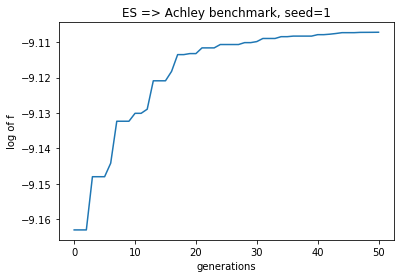

In [24]:
results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark function', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 200,
            'population': 1,
            'upper': [30],
            'lower': [-30],
            'verbose': 0,
            'max_func_eval': 0,
        }
        params['max_func_eval'] = params['population'] * 51 * 2
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = es_optimizer(py_globals[bmrk], params)
        results.append(tmp_result.copy())
        #print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        #print('\t\tf=', tmp_result['metrics']['scores'][-3:])
        print('\t\t\t f_min =', tmp_result['metrics']['all_best'])
        """
        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'ES',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )
        """

r_dim = results[0] # seed=1, ackley
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2, 0, -1])

plt.plot(-np.log(y_plot))
plt.title('ES => Achley benchmark, seed=1')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

# CMA-ES - Covariance Matrix Evolutionary Strategy algorithm

In [25]:
# impelmentation 1

if 0 > 1:
    
    results = []
    _dim = 30

    for bmrk in benchmarks:
        print('Benchmark function', bmrk)
        for seed in range(1, 2):
            params = {
                'seed': seed,
                'dimension': _dim,
                'max_iterations': 200,
                'population': 100,
                'upper': [30],
                'lower': [-30],
                'verbose': 1,
            }
            print(f'\tDimensions: {_dim}, Seed={seed}')
            tmp_result = cma_es_optimizer(ackley_function, params)
            results.append(tmp_result.copy())
            print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
            print('\t\tf=', tmp_result['metrics']['scores'][-3:, 0])

            compare_data = compare_data.append(
                pd.DataFrame(data=[[
                    'CMA-ES',
                    bmrk,
                    seed,
                    params['population'],
                    _dim,
                    params['max_iterations'],
                    params['upper'][0],
                    params['lower'][0],
                    np.amin(tmp_result['metrics']['scores'][-1]),
                    np.inf,
                    np.inf,
                    tmp_result['time_elapsed'],
                    tmp_result['n_eval']
                ]], columns=compare_cols),
                ignore_index=True
            )

    r_dim = results[0] # seed=1, ackley
    y_plot = []
    #for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    #    y_plot.append(r_dim['metrics']['scores'][_iter2])

    plt.plot(-np.log(r_dim['metrics']['objective']))
    plt.title('CMA-ES => Achley benchmark, seed=1')
    #plt.subtitle('log of f(x) for x = best')
    plt.xlabel('generations')
    plt.ylabel('log of f')

Benchmark function ackley_function
	Dimensions: 30, Seed=1
		Iteration 00000, f_min =  +3.58176e+00, x =  +4.42997e-01 n_eval = 00014 time =    0.001s
		   stopped max eval 700
			 f_min = 1.5671810977553418
Benchmark function sphere_function
	Dimensions: 30, Seed=1
		Iteration 00000, f_min =  +8.40227e+00, x =  +3.90436e-01 n_eval = 00014 time =    0.001s
		   stopped max eval 700
			 f_min = 0.6705301797920239


/home/bgcarvalho/Documents/Personal/education/04_pos_graduacao/06_Mestrado-UFES/07_Computacao-natural/PINF-6073_natural-computing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:60: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0, 0.5, 'log of f')

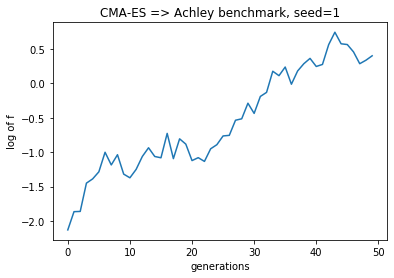

In [26]:
# impelmentation 2

results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark function', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 1000,
            'population': 100,
            'upper': [30],
            'lower': [-30],
            'verbose': 1,
            'max_func_eval': 0,
        }
        params['max_func_eval'] = params['population'] * 7 * 1
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = cma_es_optimizer2(py_globals[bmrk], params)
        results.append(tmp_result.copy())
        #print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        #print('\t\tf=', tmp_result['metrics']['scores'][0, -3:])
        print('\t\t\t f_min =', tmp_result['metrics']['all_best'])
        """
        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'CMA-ES',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )
        """

r_dim = results[0] # seed=1, ackley
y_plot = []
#for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
#    y_plot.append(r_dim['metrics']['scores'][_iter2])

plt.plot(-np.log(r_dim['metrics']['objective']))
plt.title('CMA-ES => Achley benchmark, seed=1')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

# Direct comparison

Compare results for each benchmark function.

In [38]:
# RUN ALL AGAIN

results = []
_dim = 30

compare_cols = [
    'algorithm',
    'benchmark',
    'seed',
    'population',
    'dimension',
    #'max_iter',
    'upper_bound',
    'lower_bound',
    'seed_f_min',
    #'worst',
    #'mean',
    'time',
    'n_func_eval'
]
compare_data = pd.DataFrame(columns=compare_cols)
py_globals = globals()

benchmarks = [
    'ackley_function',
    'sphere_function',
    #'rastrigin_function',
    'rosenbrock_function',
    'schwefel',
    'powell',
    #'styblinski_tang_function',
]

for bmrk in benchmarks:
    print('Benchmark:', bmrk)
    for algo_f in ['ga_optimizer', 'pso_optimizer', 'bb_pso_optimizer', 'es_optimizer', 'cma_es_optimizer2']:
        print('\toptimizer:', algo_f)
        #_w = np.inf
        #_m = []
        for seed in range(1, 11):
            params = {
                'seed': seed,
                'dimension': _dim,
                'max_iterations': 100000,
                'population': 100,
                'upper': [30],
                'lower': [-30],
                'verbose': 0,
                'max_func_eval': 2000,
            }
            params['max_func_eval'] = params['population'] * 10
            print(f'\t\t=> Dimensions: {_dim}, Seed={seed}')
            obj_func = py_globals[bmrk]
            algo = py_globals[algo_f]
            tmp_result = algo(obj_func, params)
            #results.append(tmp_result.copy())
            #print(f"\t\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
            #print('\t\t\tf=', tmp_result['metrics']['scores'][0, -3:])
            print(f'\t\t   Best_f: ', tmp_result['metrics']['all_best'])

            compare_data = compare_data.append(
                pd.DataFrame(data=[[
                    algo_f,
                    bmrk,
                    seed,
                    params['population'],
                    _dim,
                    #params['max_iterations'],
                    params['upper'][0],
                    params['lower'][0],
                    tmp_result['metrics']['all_best'],
                    #np.inf,
                    #np.inf,
                    tmp_result['time_elapsed'],
                    tmp_result['n_eval']
                ]], columns=compare_cols),
                ignore_index=True
            )
    print('=' * 100)

Benchmark: ackley_function
	optimizer: ga_optimizer
		=> Dimensions: 30, Seed=1
		   stopped max eval 1000
		   Best_f:  0.02928980904896905
		=> Dimensions: 30, Seed=2
		   stopped max eval 1000
		   Best_f:  0.07819400496489637
		=> Dimensions: 30, Seed=3
		   stopped max eval 1000
		   Best_f:  2.265044590479715
		=> Dimensions: 30, Seed=4
		   stopped max eval 1000
		   Best_f:  0.27242853281442736
		=> Dimensions: 30, Seed=5
		   stopped max eval 1000
		   Best_f:  2.3750360761725635
		=> Dimensions: 30, Seed=6
		   stopped max eval 1000
		   Best_f:  2.8443856074182468
		=> Dimensions: 30, Seed=7
		   stopped max eval 1000
		   Best_f:  2.199470897423432
		=> Dimensions: 30, Seed=8
		   stopped max eval 1000
		   Best_f:  2.7311425484034584
		=> Dimensions: 30, Seed=9
		   stopped max eval 1000
		   Best_f:  0.043200266470212245
		=> Dimensions: 30, Seed=10
		   stopped max eval 1000
		   Best_f:  0.24898904737784777
	optimizer: pso_optimizer
		=> Dimensions: 30, Seed=1
		   stop

/home/bgcarvalho/Documents/Personal/education/04_pos_graduacao/06_Mestrado-UFES/07_Computacao-natural/PINF-6073_natural-computing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:60: ComplexWarning: Casting complex values to real discards the imaginary part


		   stopped max eval 1008
		   Best_f:  0.2903084325959999
		=> Dimensions: 30, Seed=3
		   stopped max eval 1008
		   Best_f:  1.176277161417961
		=> Dimensions: 30, Seed=4
		   stopped max eval 1008
		   Best_f:  1.5425050721454103
		=> Dimensions: 30, Seed=5
		   stopped max eval 1008
		   Best_f:  0.9654705169076476
		=> Dimensions: 30, Seed=6
		   stopped max eval 1008
		   Best_f:  0.7696956515938038
		=> Dimensions: 30, Seed=7
		   stopped max eval 1008
		   Best_f:  0.940059682039593
		=> Dimensions: 30, Seed=8
		   stopped max eval 1008
		   Best_f:  2.593837917440258
		=> Dimensions: 30, Seed=9
		   stopped max eval 1008
		   Best_f:  1.4963337319740835
		=> Dimensions: 30, Seed=10
		   stopped max eval 1008
		   Best_f:  0.3315507891637428
Benchmark: sphere_function
	optimizer: ga_optimizer
		=> Dimensions: 30, Seed=1
		   stopped max eval 1000
		   Best_f:  0.0013552866372660115
		=> Dimensions: 30, Seed=2
		   stopped max eval 1000
		   Best_f:  0.007782488888867961
		=> 

		   stopped max eval 1000
		   Best_f:  139402939.8827066
		=> Dimensions: 30, Seed=9
		   stopped max eval 1000
		   Best_f:  111791749.93799685
		=> Dimensions: 30, Seed=10
		   stopped max eval 1000
		   Best_f:  127936152.56937484
	optimizer: es_optimizer
		=> Dimensions: 30, Seed=1
		stopped max eval 1000
		   stopped max eval 1000
		   Best_f:  215490719.03038573
		=> Dimensions: 30, Seed=2
		stopped max eval 1000
		   stopped max eval 1000
		   Best_f:  241036143.77551222
		=> Dimensions: 30, Seed=3
		stopped max eval 1000
		   stopped max eval 1000
		   Best_f:  199742697.1290561
		=> Dimensions: 30, Seed=4
		stopped max eval 1000
		   stopped max eval 1000
		   Best_f:  187393317.7053343
		=> Dimensions: 30, Seed=5
		stopped max eval 1000
		   stopped max eval 1000
		   Best_f:  222129935.80272555
		=> Dimensions: 30, Seed=6
		stopped max eval 1000
		   stopped max eval 1000
		   Best_f:  207012082.82817188
		=> Dimensions: 30, Seed=7
		stopped max eval 1000
		   stopped max 

		=> Dimensions: 30, Seed=4
		   stopped max eval 1000
		   Best_f:  52526.031631896265
		=> Dimensions: 30, Seed=5
		   stopped max eval 1000
		   Best_f:  178791.9677768525
		=> Dimensions: 30, Seed=6
		   stopped max eval 1000
		   Best_f:  100525.67678136326
		=> Dimensions: 30, Seed=7
		   stopped max eval 1000
		   Best_f:  60704.90693718499
		=> Dimensions: 30, Seed=8
		   stopped max eval 1000
		   Best_f:  76855.91595261329
		=> Dimensions: 30, Seed=9
		   stopped max eval 1000
		   Best_f:  91267.33383379105
		=> Dimensions: 30, Seed=10
		   stopped max eval 1000
		   Best_f:  173661.38778850448
	optimizer: bb_pso_optimizer
		=> Dimensions: 30, Seed=1
		   stopped max eval 1000
		   Best_f:  3451619.7792684846
		=> Dimensions: 30, Seed=2
		   stopped max eval 1000
		   Best_f:  2696463.1544865556
		=> Dimensions: 30, Seed=3
		   stopped max eval 1000
		   Best_f:  1464990.6966344095
		=> Dimensions: 30, Seed=4
		   stopped max eval 1000
		   Best_f:  2054965.8331907275
		=> D

In [39]:
compare_data

,algorithm,benchmark,seed,population,dimension,upper_bound,lower_bound,seed_f_min,time,n_func_eval
0,ga_optimizer,ackley_function,1,100,30,30,-30,0.029290,0.365292,1000
1,ga_optimizer,ackley_function,2,100,30,30,-30,0.078194,0.359974,1000
2,ga_optimizer,ackley_function,3,100,30,30,-30,2.265045,0.367650,1000
3,ga_optimizer,ackley_function,4,100,30,30,-30,0.272429,0.369191,1000
4,ga_optimizer,ackley_function,5,100,30,30,-30,2.375036,0.371098,1000
...,...,...,...,...,...,...,...,...,...,...
245,cma_es_optimizer2,powell,6,100,30,30,-30,9.237567,0.071599,1008
246,cma_es_optimizer2,powell,7,100,30,30,-30,29.105103,0.071056,1008
247,cma_es_optimizer2,powell,8,100,30,30,-30,13.055163,0.070669,1008
248,cma_es_optimizer2,powell,9,100,30,30,-30,17.240165,0.070517,1008


Compare results for different seeds:
- min of seed_f_min is the best overall
- max of seed_f_min is the worst


In [40]:
pt = pd.pivot_table(
    compare_data,
    #values=['best', 'worst', 'time', 'n_func_eval'],
    values=['seed_f_min', 'time', 'n_func_eval'],
    index=['benchmark', 'algorithm'],
    aggfunc={
        'seed_f_min': [np.amin, np.amax, np.mean, np.median],
        #'best': [np.amin],
        #'worst': np.amax,
        'time': np.mean,
        'n_func_eval': np.amax
    }
)
print(pt)

                                      n_func_eval    seed_f_min                                                time
                                             amax          amax          amin          mean        median      mean
benchmark           algorithm                                                                                      
ackley_function     bb_pso_optimizer         1000  2.005009e+01  1.917789e+01  1.961509e+01  1.959730e+01  0.054118
                    cma_es_optimizer2        1008  2.593838e+00  2.903084e-01  1.088693e+00  9.527651e-01  0.055078
                    es_optimizer             1000  2.043999e+01  2.012883e+01  2.025234e+01  2.021823e+01  0.014687
                    ga_optimizer             1000  2.844386e+00  2.928981e-02  1.308718e+00  1.235950e+00  0.362868
                    pso_optimizer            1000  1.161497e+01  9.391213e+00  1.048146e+01  1.052781e+01  0.049747
powell              bb_pso_optimizer         1000  3.567187e+06  1.14718

ackley_function      bb_pso_optimizer      +1.91779e+01  +0.00000e+00 5.412e-02
ackley_function      cma_es_optimizer2     +2.90308e-01  +0.00000e+00 5.508e-02
ackley_function      es_optimizer          +2.01288e+01  +0.00000e+00 1.469e-02
ackley_function      ga_optimizer          +2.92898e-02  +0.00000e+00 3.629e-01
ackley_function      pso_optimizer         +9.39121e+00  +0.00000e+00 4.975e-02
sphere_function      bb_pso_optimizer      +1.14718e+06  +0.00000e+00 7.098e-02
sphere_function      cma_es_optimizer2     +6.25757e+00  +0.00000e+00 7.166e-02
sphere_function      es_optimizer          +5.27815e+06  +0.00000e+00 2.950e-02
sphere_function      ga_optimizer          +4.41824e-02  +0.00000e+00 3.833e-01
sphere_function      pso_optimizer         +5.14565e+04  +0.00000e+00 6.584e-02
rosenbrock_function  bb_pso_optimizer      +5.72952e+07  +0.00000e+00 5.122e-02
rosenbrock_function  cma_es_optimizer2     +3.66529e+01  +0.00000e+00 5.160e-02
rosenbrock_function  es_optimizer       

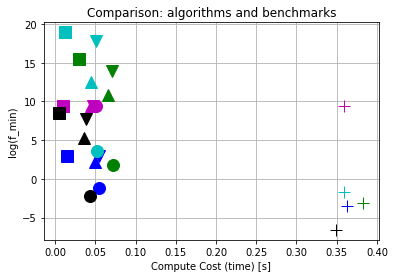

In [50]:
colors = {
    'ackley_function': 'b',
    'sphere_function': 'g',
    'rastrigin_function': 'r',
    'rosenbrock_function': 'c',
    'schwefel': 'm',
    'powell': 'k',
    'styblinski_tang_function': 'y',
}
markers = {
    'bb_pso_optimizer': 'v',
    'cma_es_optimizer2': 'o',
    'es_optimizer': 's',
    'ga_optimizer': '+',
    'pso_optimizer': '^',
}
algo = [
    'bb_pso_optimizer',
    'cma_es_optimizer2',
    'es_optimizer',
    'ga_optimizer',
    'pso_optimizer',
]
lmin = {
    'ackley_function': 0.0,
    'sphere_function': 0.0,
    'rastrigin_function': 0.0,
    'rosenbrock_function': 0.0,
    'schwefel': 0.0,
    'powell': 0.0,
    'styblinski_tang_function': 0.0,
}

#data_plot = compare_data[compare_data['benchmark'] == 'ackley_function']
#data_plot = pt.xs('ackley_function')
data_plot = pt

plt.show()
i = 0
#for c in ['ackley_function' , 'sphere_function']:
for c in benchmarks:
    #
    for m in markers:
        f_min = data_plot.iloc[i, 2]
        t_mean = data_plot.iloc[i, 5]
        i = i + 1
        if t_mean > 1e5:
            print(' skip outlier')
            continue
        mark = markers[m]
        cor = colors[c]
        print(f'{c:20s} {m:20s} {f_min:+13.5e} {lmin[c]:+13.5e} {t_mean:8.3e}')
        plt.plot(t_mean, np.log(f_min),
                 color=cor, marker=mark, linestyle='none', markersize=12)
#plt.xlim([0, 100.0])
#plt.ylim([0, 20.0])
plt.grid()
plt.title('Comparison: algorithms and benchmarks')
plt.xlabel('Compute Cost (time) [s]')
plt.ylabel('log(f_min)')
print('')
print('Circle: CMA-ES')
print('Square: ES')
print('PLus:   GA')
print('^:      PSO')
print('v:      BB-PSO')
print('')
print('Ackley:     blue')
print('Sphere:     green')
print('Rastrigin:  red')
print('Rosenbrock: cyan / light green')
print('Schwefel:   magenta / wine')
print('Powell:     black')
print('Styblinski: yellow')
print('')
print('Y-axis in LOG for better visualization')

# Conclusion

For this simple comparison, setting the limit of 2000 objective function evaluations, 
GA algorithm is consistently more computational expensive, 
and CMA-ES produces better results for most benchmarks. ES was the fastest for all the selected benchmarks.

In this short comparison, results indicate that CMA-ES can achieve best balance of computational cost and accuracy.